In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

import itertools
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt

from utils import *

# filter warnings
import warnings
warnings.filterwarnings("ignore")

seed=123

# Grid search

In [22]:
class paramsearch:
    """
    Grid search to get the best parameters

    Args:
        data (pd.DataFrame): univariate series with the data
        steps_ahead (int): number of steps ahead to forecast
        hyperparams (dict of lists): dict of hyperparams 
        split_sizes (tuple): sizes of train and validation sets. By default=(0.5,0.2).
                             (test size is 1-(0.5+0.2)=0.3 for default case)
        max_configs (int): max number of combinations to evaluate
        metricas (dict): metrics used in evaluation
    """

    def __init__(self, data, steps_ahead=14, max_configs=100, split_sizes=(0.5, 0.2), hyperparams=None, metrics=metrics):

        # store data
        self.data = data
        self.train_df = None
        self.val_df = None
        self.test_df = None

        # if no grid specified, define grid
        if hyperparams is None:
            self.hyperparams = {
                'num_neurons': [i for i in range(5, 20)],
                'num_layers': [i for i in range(1, 5)],
                'dropouts': [0.5, 0.6, 0.7, 0.8],
                'window_size': [i for i in range(10, 25)],
                'layer_type': ['lstm', 'gru', 'recurrent'],
                'activation_function': ['tanh', 'relu']}
        else:
            self.hyperparams = hyperparams

        # store attributes
        self.steps_ahead = steps_ahead
        self.max_configs = max_configs
        self.train_size = split_sizes[0]
        self.val_size = split_sizes[1]
        self.metrics = metrics
        self.tf_metrics = metrics = [RMSLETF,
                                    'mae', 
                                    tf.keras.metrics.RootMeanSquaredError(), 
                                    tf.keras.metrics.MeanAbsolutePercentageError()]

        # train config
        self.epochs = 100
        self.batch_size = 32

        # vars to store experiment results
        self.history_log = {}
        self.model_log = {}
        self.pandas_log = None
        self.all_data_from_model = {}

    def run_experiment(self, verbose=1):
        # set seed
        np.random.seed(seed)

        # generate grid
        hypergrid = list(self.generate_hypergrid())
        # subsample hypergrid (get only some combinations of hyperparameters)
        hypergrid = self.subsample_hypergrid(hypergrid)

        # 1. univariate train-val-test split
        self.train_df, self.val_df, self.test_df = self.univariate_train_test_split(
            self.data)

        # 2. scale each train-val-test split
        train_df_sc = self.scale_data(self.train_df)
        val_df_sc = self.scale_data(self.val_df)
        test_df_sc = self.scale_data(self.test_df)

        # 3. loop over hypergrid
        for hypercomb in hypergrid:
            try:
                if verbose:
                    print(hypercomb)

                # 3.1. make dataset
                X_train, Y_train = self.make_dataset(
                    window_size=hypercomb['window_size'], series=train_df_sc)
                X_val, Y_val = self.make_dataset(
                    window_size=hypercomb['window_size'], series=val_df_sc)
                X_test, Y_test = self.make_dataset(
                    window_size=hypercomb['window_size'], series=test_df_sc)

                # 3.2. build model
                model = self.build_model(hypercomb['num_layers'],
                                        hypercomb['num_neurons'],
                                        hypercomb['dropouts'],
                                        hypercomb['window_size'],
                                        hypercomb['layer_type'],
                                        hypercomb['activation_function'],
                                        self.tf_metrics)

                # 3.3. train model
                early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                patience=20,
                                                mode='min')
                history = model.fit(X_train, Y_train, validation_data=(
                    X_val, Y_val), batch_size=self.batch_size, epochs=self.epochs,
                    callbacks=[early_stopping],
                    verbose=0)

                # 3.4. store history in history dict
                self.history_log['_'.join(
                    [str(param) for param in hypercomb.values()])] = history

                # 3.5. store trained model in model dict
                self.model_log['_'.join([str(param)
                                        for param in hypercomb.values()])] = model

                # 3.6. evaluate model on validation set and store results
                result_val = self.evaluate_model(model, X_val, Y_val)
                result_val = {f'val_{k}':v for k,v in result_val.items()}
                # print(result_val)

                # 3.7. evaluate model on test set and store results
                result_test = self.evaluate_model(model, X_test, Y_test)
                result_test = {f'test_{k}':v for k,v in result_test.items()}
                # print(result_test)

                # 3.8. print combination and evaluation results on val and train
                newrow = pd.DataFrame({**hypercomb, **result_val, **result_test})
                # display(newrow)

                # 3.9. store all data from model in dict
                self.store_all_data(hypercomb, model, X_train, Y_train, X_val, Y_val, X_test, Y_test, result_val, result_test)
                # add row to metric table
                if self.pandas_log is None:
                    self.pandas_log = newrow
                else:
                    self.pandas_log = pd.concat([self.pandas_log, newrow])

            except Exception as e:
                print(e)
                continue

    def generate_hypergrid(self):
        """Returns all possible combinations 
            of the hyperparameters"""
        keys = self.hyperparams.keys()
        vals = self.hyperparams.values()
        for instance in itertools.product(*vals):
            yield dict(zip(keys, instance))

    def subsample_hypergrid(self, hypergrid):
        """Returns subsamples of the hypergrid"""
        # get self.max_configs random combinations of hyperparameters combinations
        subsamples = random.sample(range(len(hypergrid)), self.max_configs)
        subsamples = [hypergrid[i] for i in subsamples]
        print(f'Number of configs to evaluate: {len(subsamples)}')
        print('-------------------------------------------------\n')
        return subsamples

    def univariate_train_test_split(self, data):
        """Splits the data into train, val and test sets"""
        # split data into univariate train, val and test sets
        n = len(data)
        train_df = data[:int(n * self.train_size)]
        val_df = data[int(n * self.train_size):int(n * (self.train_size + self.val_size))]
        test_df = data[int(n * (self.train_size + self.val_size)):]
        return train_df, val_df, test_df

    def scale_data(self, data_subset, type='maxmin'):
        """Scales the data into [0,1] """
        if type == 'maxmin':
            return (data_subset - self.train_df.min()) / (self.train_df.max() - self.train_df.min())
        if type == 'standard':
            return (data_subset - self.train_df.mean()) / self.train_df.std()

    def descale_data(self, data_subset, type='maxmin'):
        """Descales the data into original scale"""
        if type == 'maxmin':
            return data_subset * (self.train_df.max() - self.train_df.min()) + self.train_df.min()
        if type == 'standard':
            return data_subset * self.train_df.std() + self.train_df.mean()

    def make_dataset(self, series, window_size=None, steps_ahead=None, dropna=True):
        """Prepare dataset to have two dimensions for X and y"""

        if window_size is None:
            window_size = self.window_size
        if steps_ahead is None:
            steps_ahead = self.steps_ahead

        # create a dataframe with the data
        series = pd.Series(series.values.ravel(), index=pd.DatetimeIndex(
            series.index), dtype=pd.Int8Dtype)
        # lag features
        X = pd.DataFrame({'t-'+str(i): series.shift(i)
                         for i in range(window_size)})
        # steps ahead targets
        y = pd.DataFrame({'step_'+str(i): series.shift(-i)
                         for i in range(1, steps_ahead+1)})
        # # add the lagged features to the dataframe
        # data = pd.concat({'Features': X.iloc[:,::-1], 'Targets': y}, axis=1)

        # drop nan rows
        if dropna:
            X = X.dropna()
            y = y.dropna()

        # make the index of y and X equal
        y, X = y.align(X, join='inner', axis=0)
        return np.asarray(X).astype('float32'), np.asarray(y).astype('float32')


    def build_layer(self, num_neurons, dropouts, layer_type, activation_function, last=False):
        if not last:
            if layer_type == 'lstm':
                return layers.LSTM(num_neurons, dropout=dropouts, recurrent_dropout=dropouts, return_sequences=True, activation=activation_function)
            if layer_type == 'gru':
                return layers.GRU(num_neurons, dropout=dropouts, recurrent_dropout=dropouts, return_sequences=True, activation=activation_function)
            if layer_type == 'recurrent':
                return layers.SimpleRNN(num_neurons, dropout=dropouts, recurrent_dropout=dropouts, return_sequences=True, activation=activation_function)
        else:
            if layer_type == 'lstm':
                return layers.LSTM(self.steps_ahead, dropout=dropouts, recurrent_dropout=dropouts, return_sequences=False, activation=activation_function)
            if layer_type == 'gru':
                return layers.GRU(self.steps_ahead, dropout=dropouts, recurrent_dropout=dropouts, return_sequences=False, activation=activation_function)
            if layer_type == 'recurrent':
                return layers.SimpleRNN(self.steps_ahead, dropout=dropouts, recurrent_dropout=dropouts, return_sequences=False, activation=activation_function)

    def build_model(self, num_layers, num_neurons, dropouts, window_size, layer_type, activation_function, metrics=[]):
        model = Sequential()
        model.add(layers.InputLayer(input_shape=(window_size,)))
        model.add(layers.Reshape((window_size, 1)))
        for i in range(num_layers-1):
            model.add(self.build_layer(num_neurons, dropouts,
                      layer_type, activation_function))
        model.add(self.build_layer(num_neurons, dropouts,
                  layer_type, activation_function, last=True))

        model.compile(optimizer=tf.keras.optimizers.Adam(
            learning_rate=1e-3), 
            # loss='msle', 
            loss='mse',
            metrics=metrics)

        return model

    def evaluate_model(self, model, X_data_subset=None, Y_data_subset=None):
        """Evaluates the model on (X_data_subset, Y_data_subset) set
            Those subsets are scaled.
        """
        evaluation = {}

        # 1. generate forecasts
        preds = model.predict(X_data_subset)
        
        # 2. descale the forecasts
        descaled_preds = self.descale_data(preds)
        descaled_Y_data_subset = self.descale_data(
            Y_data_subset)
        # descaled_Y_data_subset = np.asarray(Y_data_subset).astype('float32')

        # 3. evaluate the model per each step_ahead
        for i in range(self.steps_ahead):
            nn_step_evaluation = {}
            # 3.1. evaluate the model on the current step_ahead
            data_subset_step = descaled_Y_data_subset[:, i]
            predicted_step = descaled_preds[:, i]
            # 3.2. evaluate the model on the current step_ahead
            for metric_name, metric in self.metrics.items():
                nn_step_evaluation[metric_name] = metric(
                    data_subset_step, predicted_step)

            evaluation[f'step_{i+1}'] = nn_step_evaluation
        return evaluation
    
    def store_all_data(self, hypercomb, model, X_train, Y_train, X_val, Y_val, X_test, Y_test, result_val, result_test):
        results = {}
        results['hypercomb'] = hypercomb
        results['X_train'] = self.descale_data(X_train)
        results['Y_train'] = self.descale_data(Y_train)
        results['X_val'] = self.descale_data(X_val)
        results['Y_val'] = self.descale_data(Y_val)
        results['X_test'] = self.descale_data(X_test)
        results['Y_test'] = self.descale_data(Y_test)
        results['train_forecasts'] = self.descale_data(model.predict(X_train))
        results['val_forecasts'] = self.descale_data(model.predict(X_val))
        results['test_forecasts'] = self.descale_data(model.predict(X_test))
        results['result_val'] = result_val
        results['result_test'] = result_test
        self.all_data_from_model['_'.join([str(param)
                                        for param in hypercomb.values()])] = results

# Ejemplo de uso

d:\MUMOMA\TFM\COVID\COVID-Dynamics-Model-Comparison\data\final-data\spanish-covid-19-data-renave-07Jul2022.csv


<AxesSubplot:title={'center':'COVID-19 Infected (raw data)'}, xlabel='Date'>

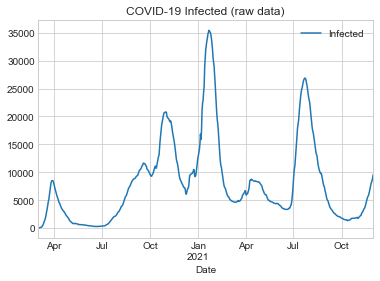

In [23]:
# read data without smoothing
df = load_last_final_data(from_folder='final')
# keep only the infected variable
df = df[['Infected']]
# represent the series
df.plot(title='COVID-19 Infected (raw data)')

In [24]:
serie = df.Infected

## Instantiate 

In [25]:
hyperparams = {
                'num_neurons': [i for i in range(5, 30)],
                'num_layers': [i for i in range(1, 5)],
                'dropouts': [0.6],
                'window_size': [i for i in range(4, 30)],
                'layer_type': ['lstm', 'gru', 'recurrent'],
                'activation_function': ['tanh', 'relu']}
                
parasect = paramsearch(serie,max_configs=100, hyperparams=hyperparams)

In [26]:
# run random grid search
parasect.run_experiment()

Number of configs to evaluate: 10
-------------------------------------------------

{'num_neurons': 13, 'num_layers': 2, 'dropouts': 0.8, 'window_size': 20, 'layer_type': 'gru', 'activation_function': 'tanh'}
{'num_neurons': 11, 'num_layers': 1, 'dropouts': 0.8, 'window_size': 16, 'layer_type': 'lstm', 'activation_function': 'relu'}
{'num_neurons': 16, 'num_layers': 2, 'dropouts': 0.5, 'window_size': 19, 'layer_type': 'gru', 'activation_function': 'relu'}
{'num_neurons': 16, 'num_layers': 4, 'dropouts': 0.7, 'window_size': 15, 'layer_type': 'lstm', 'activation_function': 'relu'}
{'num_neurons': 6, 'num_layers': 1, 'dropouts': 0.6, 'window_size': 15, 'layer_type': 'lstm', 'activation_function': 'relu'}
{'num_neurons': 14, 'num_layers': 2, 'dropouts': 0.7, 'window_size': 11, 'layer_type': 'recurrent', 'activation_function': 'relu'}
{'num_neurons': 11, 'num_layers': 4, 'dropouts': 0.7, 'window_size': 23, 'layer_type': 'gru', 'activation_function': 'tanh'}
{'num_neurons': 13, 'num_layers'

In [27]:
# show nn config and its metrics
parasect.pandas_log

,num_neurons,num_layers,dropouts,window_size,layer_type,activation_function,val_step_1,val_step_2,val_step_3,val_step_4,...,test_step_5,test_step_6,test_step_7,test_step_8,test_step_9,test_step_10,test_step_11,test_step_12,test_step_13,test_step_14
RMSLE,13,2,0.8,20,gru,tanh,0.368055,0.426188,0.402105,0.438300,...,0.804522,0.816259,0.837054,0.816820,0.840245,0.901225,0.915415,0.930157,0.951433,0.981350
MAE,13,2,0.8,20,gru,tanh,2497.889160,3024.244141,2754.983154,3079.983887,...,5032.013184,5220.632812,5229.851562,5292.530762,5535.073730,5781.659180,5856.198242,6271.807617,6217.395508,6917.218750
RMSE,13,2,0.8,20,gru,tanh,3316.160400,4074.142578,3579.785645,4006.392090,...,6189.552246,6578.429688,6669.904297,6713.633301,7033.108398,7185.042969,7200.903320,7830.734375,7833.184082,8636.637695
MAPE,13,2,0.8,20,gru,tanh,0.372277,0.449692,0.423447,0.474644,...,1.060824,1.054089,1.083982,1.042300,1.074624,1.234130,1.274819,1.265852,1.291089,1.349442
RMSLE,11,1,0.8,16,lstm,relu,2.699229,0.214901,0.241671,0.303436,...,0.716145,0.724803,0.772627,0.781457,0.761071,0.811158,0.810184,0.847110,0.888947,0.901205
MAE,11,1,0.8,16,lstm,relu,5841.045898,1557.176270,1653.400269,2148.956543,...,4195.980469,4360.995605,4583.093750,4774.337402,4743.127930,4981.215332,5016.602051,5279.243164,5650.365723,5848.604492
RMSE,11,1,0.8,16,lstm,relu,8424.773438,1908.793091,2070.433105,2808.641113,...,5968.721680,6597.094727,7112.337402,6634.034180,6875.025391,6809.919922,7323.061523,7380.873535,7377.149414,7667.194824
MAPE,11,1,0.8,16,lstm,relu,0.580404,0.192289,0.200768,0.281636,...,0.802913,0.744380,0.764157,0.901752,0.792425,0.957007,0.846715,0.959651,1.125069,1.116636
RMSLE,16,2,0.5,19,gru,relu,0.252795,0.328305,0.330782,0.324085,...,0.641714,1.308322,1.921761,0.860505,1.125435,0.902432,1.142521,1.202504,0.902823,0.902003
MAE,16,2,0.5,19,gru,relu,1746.063599,2225.955322,2127.184326,2041.597656,...,3967.640625,4484.137695,4635.192871,4533.829590,4848.495117,4957.198730,5210.141602,5517.930664,5323.343262,5390.829102


In [28]:
# show history from model training
parasect.history_log

{'13_2_0.8_20_gru_tanh': <keras.callbacks.History at 0x1666dcebee0>,
 '11_1_0.8_16_lstm_relu': <keras.callbacks.History at 0x1662c58ed90>,
 '16_2_0.5_19_gru_relu': <keras.callbacks.History at 0x16630ad27f0>,
 '16_4_0.7_15_lstm_relu': <keras.callbacks.History at 0x16638535fd0>,
 '6_1_0.6_15_lstm_relu': <keras.callbacks.History at 0x1668e9e7bb0>,
 '14_2_0.7_11_recurrent_relu': <keras.callbacks.History at 0x166910162b0>,
 '11_4_0.7_23_gru_tanh': <keras.callbacks.History at 0x166946a6c10>,
 '13_4_0.5_13_gru_relu': <keras.callbacks.History at 0x166a1b14c40>,
 '19_3_0.7_11_gru_tanh': <keras.callbacks.History at 0x166b0ff3c10>,
 '5_3_0.6_11_recurrent_relu': <keras.callbacks.History at 0x166bac0f1f0>}

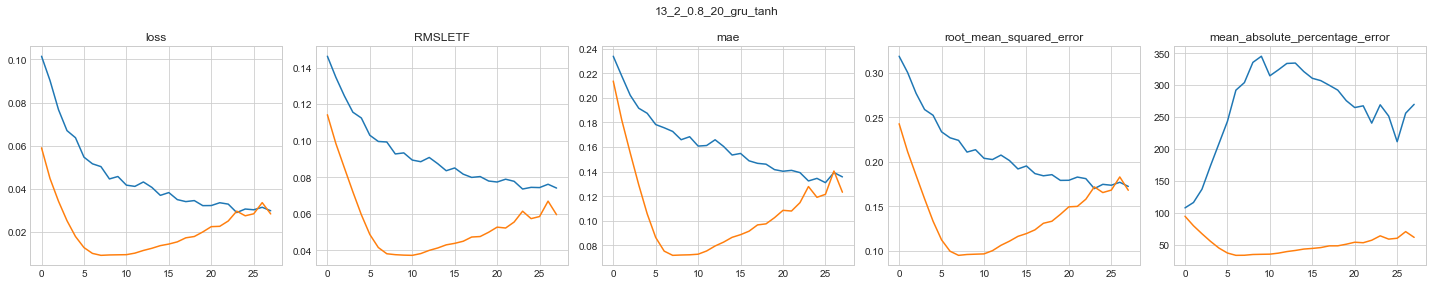

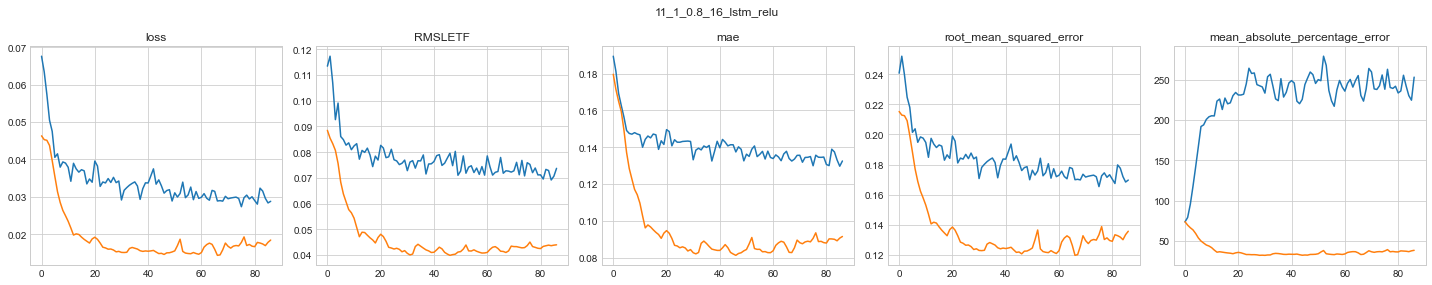

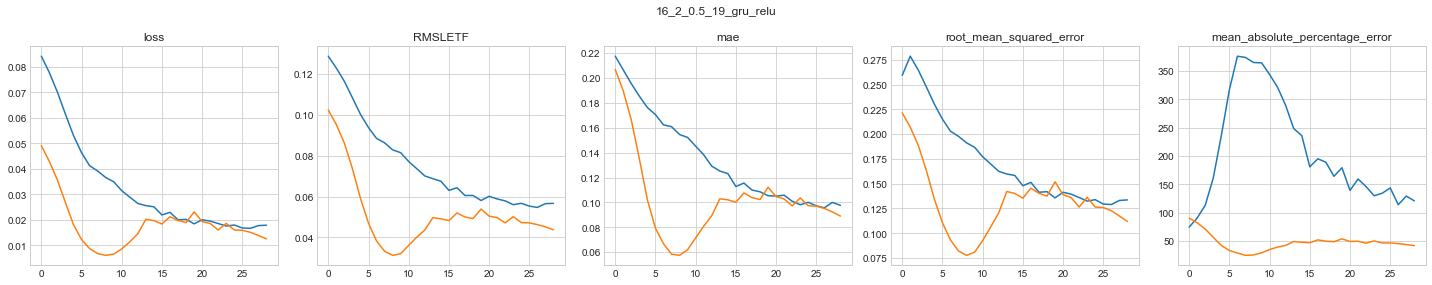

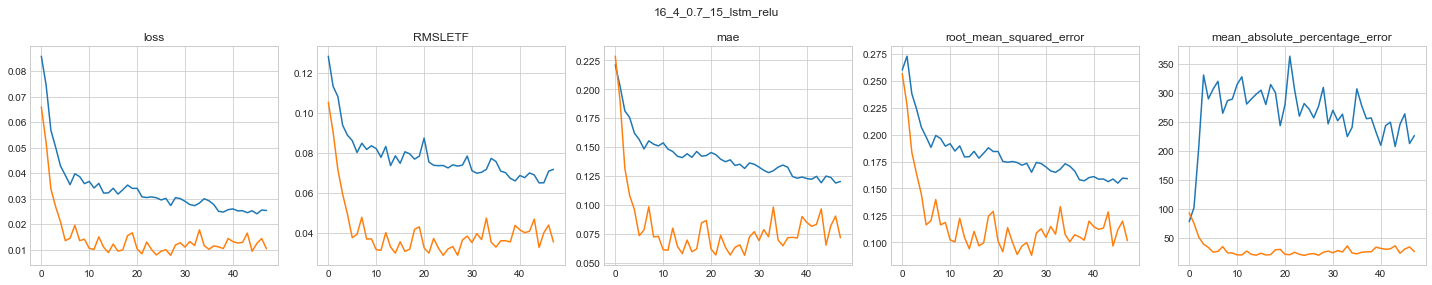

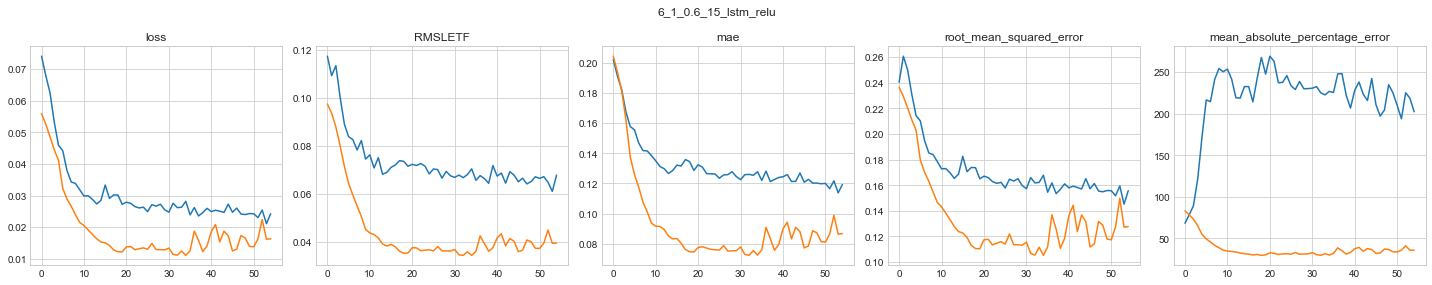

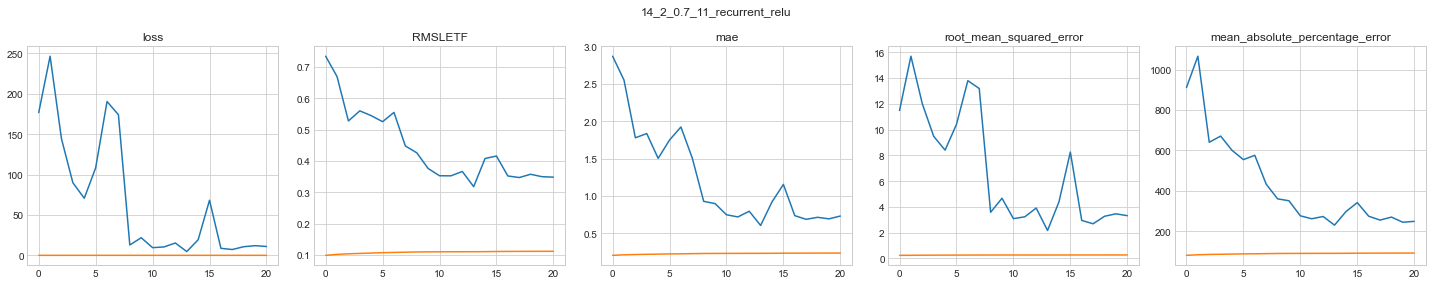

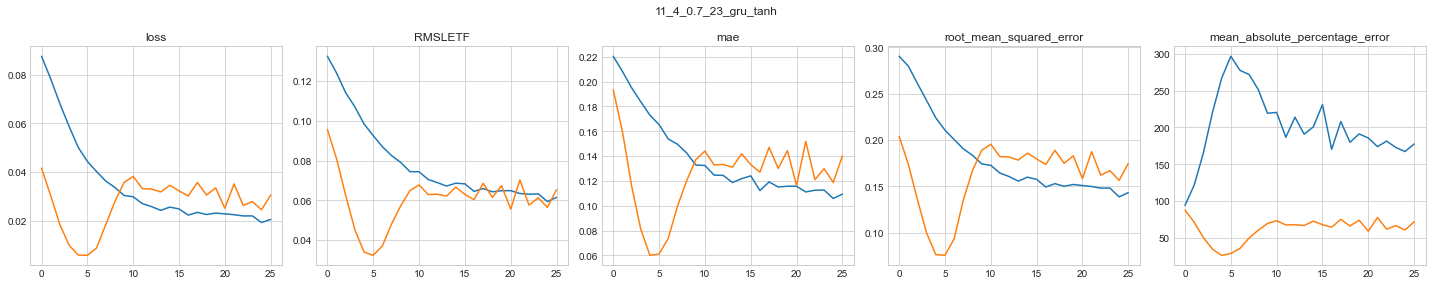

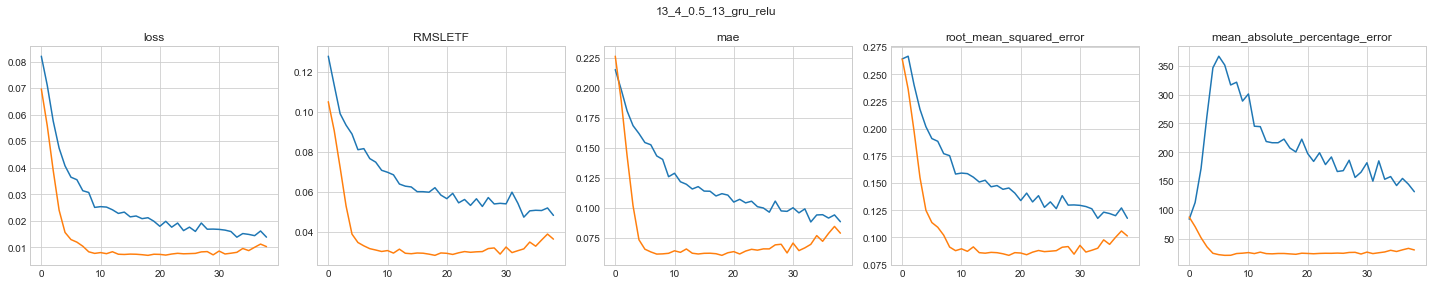

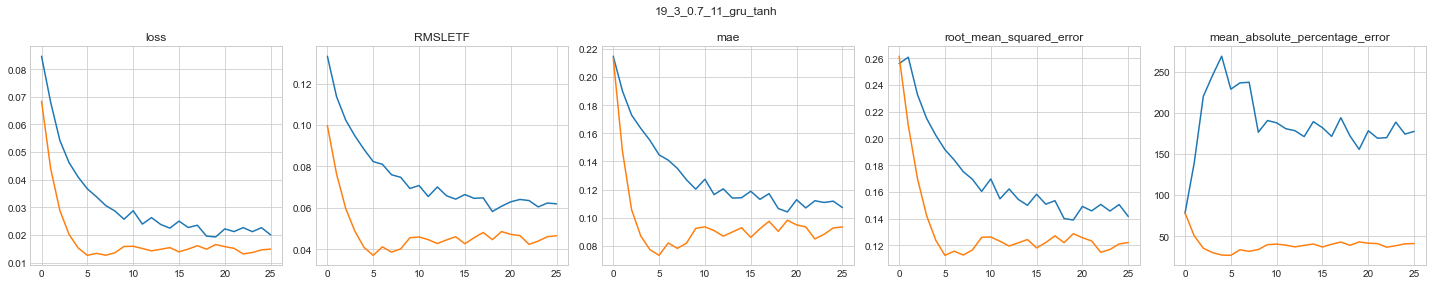

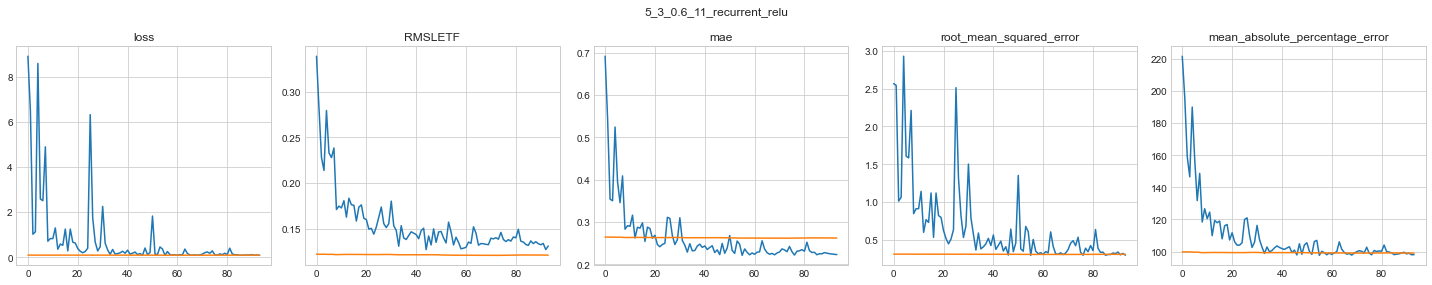

In [44]:
for log_key in parasect.history_log:
    fig, axs = plt.subplots(1,5, figsize=(20, 4), tight_layout=True)

    axs[0].plot(parasect.history_log[log_key].history['loss'], label='loss')
    axs[0].plot(parasect.history_log[log_key].history['val_loss'], label='val_loss')
    axs[0].set_title('loss')

    axs[1].plot(parasect.history_log[log_key].history['RMSLETF'], label='RMSLETF')
    axs[1].plot(parasect.history_log[log_key].history['val_RMSLETF'], label='val_RMSLETF')
    axs[1].set_title('RMSLETF')

    axs[2].plot(parasect.history_log[log_key].history['mae'], label='mae')
    axs[2].plot(parasect.history_log[log_key].history['val_mae'], label='val_mae')
    axs[2].set_title('mae')

    axs[3].plot(parasect.history_log[log_key].history['root_mean_squared_error'], label='root_mean_squared_error')
    axs[3].plot(parasect.history_log[log_key].history['val_root_mean_squared_error'], label='val_root_mean_squared_error')
    axs[3].set_title('root_mean_squared_error')

    axs[4].plot(parasect.history_log[log_key].history['mean_absolute_percentage_error'], label='mean_absolute_percentage_error')
    axs[4].plot(parasect.history_log[log_key].history['val_mean_absolute_percentage_error'], label='val_mean_absolute_percentage_error')
    axs[4].set_title('mean_absolute_percentage_error')

    plt.suptitle(f'{log_key}')
    plt.show()

In [30]:
# models
parasect.model_log

{'13_2_0.8_20_gru_tanh': <keras.engine.sequential.Sequential at 0x16616521eb0>,
 '11_1_0.8_16_lstm_relu': <keras.engine.sequential.Sequential at 0x1662c514580>,
 '16_2_0.5_19_gru_relu': <keras.engine.sequential.Sequential at 0x16630ad24c0>,
 '16_4_0.7_15_lstm_relu': <keras.engine.sequential.Sequential at 0x16630ac57c0>,
 '6_1_0.6_15_lstm_relu': <keras.engine.sequential.Sequential at 0x166373eb430>,
 '14_2_0.7_11_recurrent_relu': <keras.engine.sequential.Sequential at 0x1668e9b4d90>,
 '11_4_0.7_23_gru_tanh': <keras.engine.sequential.Sequential at 0x16690fd7eb0>,
 '13_4_0.5_13_gru_relu': <keras.engine.sequential.Sequential at 0x166a1969820>,
 '19_3_0.7_11_gru_tanh': <keras.engine.sequential.Sequential at 0x16690fb4f40>,
 '5_3_0.6_11_recurrent_relu': <keras.engine.sequential.Sequential at 0x166afeaa970>}

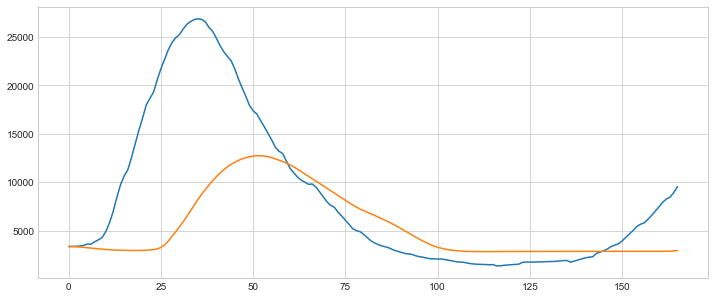

In [35]:
model_keys = list(parasect.all_data_from_model.keys())

model_results = parasect.all_data_from_model['13_4_0.5_13_gru_relu']
test_forecasts = model_results['test_forecasts']
test = model_results['Y_test']

fig = plt.figure(figsize=(12, 5))
plt.plot(test[:,-1], label='real')
plt.plot(test_forecasts[:, -1], label='predicted')


In [32]:
pd.DataFrame(model_results['result_test'])

,test_step_1,test_step_2,test_step_3,test_step_4,test_step_5,test_step_6,test_step_7,test_step_8,test_step_9,test_step_10,test_step_11,test_step_12,test_step_13,test_step_14
RMSLE,5.168156,5.329976,4.991137,5.333437,5.006510,5.338132,5.341309,3.767251,5.349348,5.354099,5.359154,5.364388,2.273658,5.376236
MAE,8064.222656,8084.654785,8042.605469,8101.755859,8049.775391,8125.505859,8141.958496,8052.547852,8184.863281,8211.071289,8239.428711,8269.083008,7650.586426,8338.744141
RMSE,11309.728516,11341.490234,11254.675781,11348.735352,11246.831055,11359.139648,11366.615234,11284.681641,11387.061523,11400.189453,11414.744141,11430.167969,10934.212891,11468.493164
MAPE,0.991880,0.992626,0.990157,0.992646,0.989372,0.992672,0.992689,0.965520,0.992731,0.992755,0.992781,0.992807,0.832342,0.992865


# Get best model 


In [33]:
compare_evals = {}
for model_name in model_keys:
    model_results = parasect.all_data_from_model[model_name]
    eval_on_step_14 = model_results['result_test']['test_step_14']
    compare_evals[model_name] = eval_on_step_14

In [34]:
pd.DataFrame(compare_evals).style.highlight_min(axis=1)

,13_2_0.8_20_gru_tanh,11_1_0.8_16_lstm_relu,16_2_0.5_19_gru_relu,16_4_0.7_15_lstm_relu,6_1_0.6_15_lstm_relu,14_2_0.7_11_recurrent_relu,11_4_0.7_23_gru_tanh,13_4_0.5_13_gru_relu,19_3_0.7_11_gru_tanh,5_3_0.6_11_recurrent_relu
RMSLE,0.981350,0.901205,0.902003,0.795054,0.849800,5.376236,0.942925,0.765851,0.811771,5.376236
MAE,6917.218750,5848.604492,5390.829102,4901.073730,5606.464844,8338.744141,6378.474121,4446.579590,5095.621094,8338.744141
RMSE,8636.637695,7667.194824,7722.231934,7623.038086,7642.456055,11468.493164,7913.445312,7260.558594,6469.102539,11468.493164
MAPE,1.349442,1.116636,0.735832,0.688014,0.930564,0.992865,1.311887,0.521151,1.035319,0.992865
